## Building a chatbot with multiple tools using langgraph"

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke('Attention is all you need')

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke('What is machine learning?')

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [37]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN']=os.getenv('HF_TOKEN')
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')

In [7]:
from langchain_tavily import TavilySearch

travily = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [8]:
travily.invoke('provide me the mostv recent ai news for 14 August 2025')

{'query': 'provide me the mostv recent ai news for 14 August 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.youtube.com/watch?v=tmMedNS6D8Q',
   'title': 'AI News — August 14, 2025: GPT-5, Copilot, GPT-OSS, Genie 3…',
   'content': 'AI recap for August 14, 2025: GPT-5 becomes the default model, Copilot adopts GPT-5, GPT-OSS 20B/120B, Claude Opus 4.1, Genie 3, and more.',
   'score': 0.8479807,
   'raw_content': None},
  {'url': 'https://dwealth.news/2025/08/ai-intelligence-weekly-top-10-8-14-25/',
   'title': 'AI INTELLIGENCE | Weekly Top 10 (8/14/25) - Dwealth.news',
   'content': 'Viral AI stories this week: USAi launch, Illinois AI therapy ban, GPT-5 price shake-up, and a viral Reddit engagement to an AI chatbot.',
   'score': 0.83452857,
   'raw_content': None},
  {'url': 'https://www.artificialintelligence-news.com/',
   'title': 'AI News | Latest AI News, Analysis & Events',
   'content': "... AI giant's plan to train its ne

In [9]:
### Combine all tools in a list

tools=[arxiv,wiki,travily]

### Initialize llm model

from langchain_groq import ChatGroq

llm=ChatGroq(model='qwen/qwen3-32b')

llm_with_tools=llm.bind_tools(tools)

In [10]:
from langchain_core.messages import HumanMessage,AIMessage

llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me see which tool to use. The available tools are arxiv, wikipedia, and tavily_search. Since they want recent news, arxiv is for academic papers, wikipedia might not have the latest updates, and tavily_search is optimized for current events. So I should use tavily_search.\n\nNow, looking at the parameters for tavily_search. The user wants recent news, so I need to set the time_range. The options are day, week, month, year. The user said "recent," which is a bit vague, but maybe "week" is a safe bet to get the latest updates. Also, the topic parameter: the default is general, but since it\'s about news, maybe setting topic to "news" would be better. Wait, the description says to use "news" only for politics, sports, or major events covered by mainstream media. AI news could be general or part of tech news. Hmm, maybe the general topic is okay, but the user specified "recent AI

In [11]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [12]:
## Entire chatbot with Langgraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# build graph
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)

builder.add_edge('tools',END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

<IPython.core.display.Image object>

In [13]:

messages=graph.invoke({"messages":"What is attention is all you need?"})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is attention is all you need?
================================== Ai Message ==================================
Tool Calls:
  arxiv (adgadd18k)
 Call ID: adgadd18k
  Args:
    query: attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


## React Agent Architecture in LangGraph

1. act = The model calls the specific tools
2. observe = Passes the output back to the model
3. reason = Based on the output response of the tool, the model will decide what to do in the next step --> smart agents

In [14]:
os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_PROJECT']=os.getenv('LANGCHAIN_PROJECT')

In [15]:
## Custom functions --> tools

def multiply(a: int,b: int)->int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int,b: int)->int:
    """
    Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int,b: int)->int:
    """
    Subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

def divide(a: int,b: int)->int:
    """
    Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a // b

In [16]:
## Travily search tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/ly/spbnwbv12839h6wrzlnkytf00000gn/T/ipykernel_8937/2492452247.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [17]:
tavily.invoke("Provide me the latest news on Independence day today -  15'th Aug, 2025")

[{'title': "What were the key announcements in PM Modi's Independence Day ...",
  'url': 'https://www.thehindu.com/news/national/what-were-the-key-announcements-in-pm-modis-independence-day-2025-speech/article69935897.ece',
  'content': 'Published - August 15, 2025 11:18 am IST\n\nPrime Minister Narendra Modi being accorded a Guard of Honour during the 79th Independence Day celebration at the Red Fort, in New Delhi, Friday, Aug. 15, 2025.\n\nPrime Minister Narendra Modi being accorded a Guard of Honour during the 79th Independence Day celebration at the Red Fort, in New Delhi, Friday, Aug. 15, 2025.\n| Photo Credit: - [...] Prime Minister Narendra Modi on Friday (August 15, 2025) delivered a 103-minute Independence Day speech from the ramparts of the Red Fort, the longest by any prime minister in India’s history. Mr. Modi broke his 98-minute record from the 78th Independence Day last year. [...] His longest Independence Day speech before 2024 was 96 minutes in 2016, while his shortest 

In [18]:
tools=[tavily,arxiv,wiki,add,multiply,subtract,divide]


In [19]:
llm_with_tools=llm.bind_tools(tools)

In [20]:
from pprint import pprint

from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")]).tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest news on Independence day 15th Aug 2025'},
  'id': 'm74ge03cx',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': '887m4a4ps',
  'type': 'tool_call'},
 {'name': 'multiply',
  'args': {'a': 4, 'b': 6},
  'id': 'abxvjneaz',
  'type': 'tool_call'},
 {'name': 'divide',
  'args': {'a': 24, 'b': 3},
  'id': 'e1vm3j9g7',
  'type': 'tool_call'},
 {'name': 'subtract',
  'args': {'a': 8, 'b': 5},
  'id': '1gc73wzmx',
  'type': 'tool_call'}]

In [21]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [22]:
## chatbot node functionality

def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}



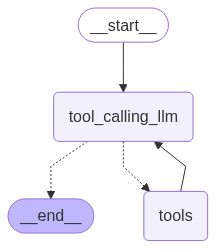

In [23]:
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END

builder=StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)
builder.add_edge('tools','tool_calling_llm')


graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
messages=graph.invoke({"messages":HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")}) # type: ignore
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (5t49ka4z6)
 Call ID: 5t49ka4z6
  Args:
    query: latest news on Independence day 15th Aug 2025
  add (r09yz75n4)
 Call ID: r09yz75n4
  Args:
    a: 2
    b: 2
  multiply (d6523t50e)
 Call ID: d6523t50e
  Args:
    a: 4
    b: 6
  divide (d7t7rmqvv)
 Call ID: d7t7rmqvv
  Args:
    a: 24
    b: 3
  subtract (j0fqncvb6)
 Call ID: j0fqncvb6
  Args:
    a: 8
    b: 5
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What were the key announcements in PM Modi's Independence Day ...", "url": "https://www.thehindu.com/news/national/what-were-the-key-an

## Agent with memory in LangGraph

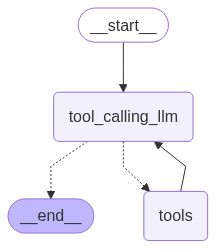

In [25]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_with_memory=builder.compile(checkpointer=memory) ## saved in memory

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
## specify the thread

config={
    "configurable":{"thread_id":"1"} ## specific to one user
}
messages=graph_with_memory.invoke({"messages":HumanMessage(content=f"Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it")},config=config) # type: ignore
for message in messages['messages']:
    message.pretty_print()


================================ Human Message =================================

Provide me the latest news on Independence day today -  15'th Aug, 2025. Also after that give me the result of 2 plus 2 multiply by 6 divided by 3. subtract 5 from it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (wjp5wrv07)
 Call ID: wjp5wrv07
  Args:
    query: latest news on Independence day 15th Aug 2025
  divide (jyn2we4r0)
 Call ID: jyn2we4r0
  Args:
    a: 6
    b: 3
  multiply (ehja8gr83)
 Call ID: ehja8gr83
  Args:
    a: 2
    b: 2
  add (y45tzmq4k)
 Call ID: y45tzmq4k
  Args:
    a: 2
    b: 4
  subtract (e00dcd9eq)
 Call ID: e00dcd9eq
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What were the key announcements in PM Modi's Independence Day ...", "url": "https://www.thehindu.com/news/national/what-were-the-key-ann

In [27]:
from typing import Annotated,List
from typing_extensions import Literal
import operator
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

planner=llm.with_structured_output(Sections)

In [28]:
### Creating Workers Dynamically in LangGraph

from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic:str
    sections:list[Section]
    completed_sections: Annotated[list,operator.add]
    final_report:str

class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[list,operator.add]

/var/folders/ly/spbnwbv12839h6wrzlnkytf00000gn/T/ipykernel_8937/339909892.py:3: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [29]:
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections=planner.invoke(
        [
            SystemMessage(content='Generate a plan for the report.'),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print('Report Sections:',report_sections)

    return {"sections":report_sections.sections} #type:ignore

In [30]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [31]:
urls = [
    "https://langchain-ai.github.io/langgraph/",
    "https://namastedev.com/blog/organizing-tasks-with-trello-boards-2/",
    "https://namastedev.com/blog/introduction-to-backtracking/"
]

docs=[WebBaseLoader(urls).load() for url in urls]

In [33]:
doc_list=[item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=100)
docs_splits=text_splitter.split_documents(doc_list)

In [39]:
vectorstore = FAISS.from_documents(
    documents=docs_splits,
    embedding=OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever()

In [40]:
retriever.invoke("What is backtracking?")

[Document(id='3094a05b-8d7c-44a1-b176-dd32f56ceeef', metadata={'source': 'https://langchain-ai.github.io/langgraph/', 'title': 'LangGraph', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='Durable execution: Build agents that persist through failures and can run for extended periods, automatically resuming from exactly where they left off.\nHuman-in-the-loop: Seamlessly incorporate human oversight by inspecting and modifying agent state at any point during execution.\nComprehensive memory: Create truly stateful agents with both short-term working memory for ongoing reasoning and long-term persistent memory across sessions.\nDebugging with LangSmith: Gain deep visibility into complex agent behavior with visualization tools that trace execution paths, capture state transitions, and provide detailed runtime metrics.\nProduction-ready deployment: Deploy sophisticated agent systems confidently with scalable infrastructure desi

In [41]:
## retriever --> Retriever tools

from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "serch and run information about langgraph"
)

In [ ]:
tools = [retriever_tool]